In [1]:
using Cropbox

WebIO._IJuliaInit()

In [2]:
using CSV
using DataFrames
using DataFramesMeta
using Dates
using Statistics
using Unitful

# 1. Implementation

## 1.1. Data

In [3]:
load_met(station) = begin
    df = CSV.read("./data/ghcnd/$station.csv", DataFrame)
    df = rename(df, "date" => "date (:Date)", "Tavg" => "Tavg (°C)") |> unitfy

    # dropmissing!(df)
end

load_met (generic function with 1 method)

In [4]:
load_obs(station, code) = begin
    s   = String(station)
    tag = code === :CE ? "CE" : "K"
    df  = CSV.read(joinpath("data","$(s)_$(tag).csv"), DataFrame) |> unitfy
    rename!(df, "bloom_doy" => "doy")
    #rename!(df, Dict(n => Symbol(n) for n in names(df)))
end

load_obs (generic function with 1 method)

## 1.2. Model

In [5]:
@system Temperature begin
    calendar(context)      ~ ::Calendar
    date(calendar.date)    ~ track::date

    data                   ~ provide(parameter, index = :date, init = date)
    T: temperature         ~ drive(from = data, by = :Tavg, u"°C")
end


Temperature

## 1.2.1. Chilling-Forcing (CF) Model

In [6]:
@system CF(Temperature, Controller) begin
    Tc: temperature_threshold ~ preserve(parameter, u"°C")
    Rc: chilling_requirement  ~ preserve(parameter, u"K")
    Rf: forcing_requirement   ~ preserve(parameter, u"K")

    y(t = calendar.last): year => Dates.year(t)      ~ preserve::int
    doy(t = date): day_of_year => Dates.dayofyear(t) ~ track::int(u"d")

    Ta(T)                                    ~ track(min = 0, u"°C")
    Δt(context.clock.step)                   ~ preserve(u"d")
    ΔT(Ta, Tc, Δt)         => (Ta - Tc) / Δt ~ track(u"K/d")

    c(ΔT): chilling             ~ track(max = 0, u"K/d")
    C(c):  chilling_accumulated ~ accumulate(when = !d, u"K")

    d(C, Rc):    chilling_done => (C <= Rc) ~ flag

    f(ΔT): forcing              ~ track(min = 0, u"K/d")
    F(f):  forcing_accumulated  ~ accumulate(when = d, u"K")

    match(F, Rf)                       => (F >= Rf) ~ flag
    stop(m = match, s = calendar.stop) => (m || s)  ~ flag
end

CF

## 1.2.2. Days Transferred to Standard Temperature (DTS) Model

In [7]:
@system DTS(Temperature, Controller) begin
    Ts: standard_temperature     ~ preserve(parameter, u"°C")
    Ea: temperature_sensitivity  ~ preserve(parameter, u"kJ/mol")
    Rd: accumulation_requirement ~ preserve(parameter)

    y(t = calendar.last): year => Dates.year(t)      ~ preserve::int
    doy(t = date): day_of_year => Dates.dayofyear(t) ~ track::int(u"d")

    R:       gas_constant                  => u"R" ~ preserve(u"J/K/mol")
    Tk(T):   absolute_temperature                  ~ track(u"K")
    Tsk(Ts): absolute_standard_temperature         ~ track(u"K")

    Δt:                     timestep     => 1                                           ~ preserve(u"d")
    ΔT(Tk, Tsk, Ea, R, Δt): rate         => (ℯ^(Ea * (Tk - Tsk) / (R * Tk * Tsk)) / Δt) ~ track(u"d^-1")
    D(ΔT):                  accumulation                                                ~ accumulate

    match(D, Rd)                       => (D >= Rd) ~ flag
    stop(m = match, s = calendar.stop) => (m || s)  ~ flag
end

DTS

## 1.2.3. Growung Degree Days (GDD) Model

In [8]:
@system GDD(Temperature, Controller) begin
    # T:  temperature         ~ preserve(parameter, u"°C")
    # T:  temperature         ~ track(u"°C")
    
    Tb: base_temperature    ~ preserve(parameter, u"°C")
    To: optimal_temperature ~ preserve(parameter, u"°C")
    Rg: gdd_requirement ~ preserve(parameter, u"K*d")
    
    y(t = calendar.last): year => Dates.year(t)      ~ preserve::int
    doy(t = date): day_of_year => Dates.dayofyear(t) ~ track::int(u"d")
    
    GDD(T, Tb, To): growing_degree_day => begin
        max(min(T, To) - Tb, 0u"K")
    end ~ track(u"K")
    
    cGDD(GDD): cumulative_growing_degree_day ~ accumulate(u"K*d")
    
    match(cGDD, Rg) => (cGDD >= Rg) ~ flag
    stop(m = match, s = calendar.stop) => (m || s) ~ flag
end

GDD

## 1.3. Configuration

In [9]:
configure(station, year) = @config (
    :Temperature => (;
        data = @subset(load_met(station), Date(year-1, 10, 1) .<= :date .<= Date(year, 6, 15)),
    ),
    :Calendar => (;
        init = ZonedDateTime(year-1, 10,  1, tz"Asia/Seoul"),
        last = ZonedDateTime(year,    6, 15, tz"Asia/Seoul"),
    ),
    :Clock => (;
        step = 1u"d",
    ),
)

configure (generic function with 1 method)

## 1.4. Estimation

In [10]:
callback(s, m) = if s.stop' && !s.match'
    m.result[end][:doy] = 365u"d"
end

callback (generic function with 1 method)

In [11]:
estimate(S, station, years;
    config,
    index = :year,
    target = :doy,
    stop = :stop,
    kw...
) = simulate(S;
    configs = @config(config + configure.(station, years)),
    index,
    target,
    stop,
    snap = stop,
    callback,
    kw...
)

estimate (generic function with 1 method)

In [12]:
#앙상블 평균

estimate2(Ss, station, years; configs, target = :doy, kw...) = begin
    Es = [estimate(S, station, years; config, target, kw...) for (S, config) in zip(Ss, configs)]
    key = Cropbox.parsetarget(target, nothing) |> only |> first
    M = mean([getproperty(E, key) for E in Es])
    DataFrame([:year => years, key => unitfy(round.(Int, deunitfy(M, u"d")), u"d")])
end

estimate2 (generic function with 1 method)

## 1.5. Evaluation & Visualization

In [13]:
assess(S, obs, station, years; config, kw...) = begin
    est = estimate(S, station, years; config)
    evaluate(obs, est; index = :year, target = :doy, kw...)
end


assess (generic function with 1 method)

In [14]:
assess2(Ss, obs, station, years; configs, kw...) = begin
    est = estimate2(Ss, station, years; configs)
    evaluate(obs, est; index = :year, target = :doy, kw...)
end

assess2 (generic function with 1 method)

In [15]:
compare(S, obs, station, years; config, kw...) = begin
    E = estimate(S, station, years; config)
    O = obs[obs.year .∈ Ref(years), :]
    p = visualize(O, :year, :doy; name = "Obs", kind = :scatterline, kw...)
    visualize!(p, E, :year, :doy; name = "Model", kind = :scatterline)
end

compare (generic function with 1 method)

In [16]:
compare2(Ss, obs, station, years; configs, kw...) = begin
    E = estimate2(Ss, station, years; configs)
    O = obs[obs.year .∈ Ref(years), :]
    p = visualize(O, :year, :doy; name = "Obs", kind = :scatterline, kw...)
    visualize!(p, E, :year, :doy; name = "Model", kind = :scatterline)
end

compare2 (generic function with 1 method)

# 2. Calibration

## 2.1. Naju

In [17]:
met_Naju = load_met(:Naju);

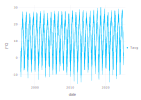

In [18]:
visualize(met_Naju, :date, :Tavg; kind = :line)

In [19]:
years_Naju = vcat(collect(1997), collect(1999:2008), collect(2013), collect(2015:2019))

17-element Vector{Int64}:
 1997
 1999
 2000
 2001
 2002
 2003
 2004
 2005
 2006
 2007
 2008
 2013
 2015
 2016
 2017
 2018
 2019

In [20]:
years_Naju = [1997; 1999:2008; 2013; 2015:2019]

17-element Vector{Int64}:
 1997
 1999
 2000
 2001
 2002
 2003
 2004
 2005
 2006
 2007
 2008
 2013
 2015
 2016
 2017
 2018
 2019

### 2.1.1. Naju * CE

In [21]:
obs_Naju_CE = load_obs(:Naju, :CE)

Row,location,lat,long,alt,year,cultivar,bloom_date,doy
,String7,Missing,Missing,Missing,Int64,String15,Date,Quantity…
1,naju,missing,missing,missing,1997,Campbell Early,1997-06-01,152 d
2,naju,missing,missing,missing,1999,Campbell Early,1999-05-26,146 d
3,naju,missing,missing,missing,2000,Campbell Early,2000-06-02,154 d
4,naju,missing,missing,missing,2001,Campbell Early,2001-05-25,145 d
5,naju,missing,missing,missing,2002,Campbell Early,2002-05-25,145 d
6,naju,missing,missing,missing,2003,Campbell Early,2003-05-23,143 d
7,naju,missing,missing,missing,2004,Campbell Early,2004-05-27,148 d
8,naju,missing,missing,missing,2005,Campbell Early,2005-05-28,148 d
9,naju,missing,missing,missing,2006,Campbell Early,2006-05-29,149 d


In [22]:
obs_Naju_CE = DataFrames.select(obs_Naju_CE, [:year, :doy])   # ← DataFrames.select로 확실히

Row,year,doy
,Int64,Quantity…
1,1997,152 d
2,1999,146 d
3,2000,154 d
4,2001,145 d
5,2002,145 d
6,2003,143 d
7,2004,148 d
8,2005,148 d
9,2006,149 d


In [23]:
# obs_Naju_CE.year = Int.(obs_Naju_CE.year)
# if !(eltype(obs_Naju_CE.doy) <: Unitful.AbstractQuantity)
#     obs_Naju_CE.doy .= Int.(obs_Naju_CE.doy) .* Unitful.u"d"
# end

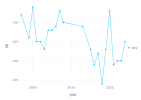

In [24]:
visualize(obs_Naju_CE, :year, :doy; kind = :scatterline)

#### CF

In [25]:
obs_Naju_CE

Row,year,doy
,Int64,Quantity…
1,1997,152 d
2,1999,146 d
3,2000,154 d
4,2001,145 d
5,2002,145 d
6,2003,143 d
7,2004,148 d
8,2005,148 d
9,2006,149 d


In [26]:
config_cf_Naju_CE = calibrate(CF, obs_Naju_CE;
    configs = configure.(:Naju, years_Naju),
    index = :year,
    target = :doy,
    parameters = CF => (;
        Tc = (0, 20),
        Rc = (-1000, 0),
        Rf = (0, 1000),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 2411 evals, 2307 steps, improv/step: 0.261 (last = 0.2614), fitness=31.000000000
20.00 secs, 4801 evals, 4697 steps, improv/step: 0.226 (last = 0.1925), fitness=28.000000000

Optimization stopped after 5001 steps and 21.33 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 234.41
Function evals per second = 239.29
Improvements/step = 0.22480
Total function evaluations = 5105


Best candidate found: [7.31225, -620.496, 370.114]

Fitness: 28.000000000



Tc,=,7.31225 °C
Rc,=,-620.496 K
Rf,=,370.114 K


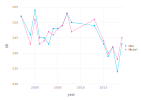

In [27]:
compare(CF, obs_Naju_CE, :Naju, years_Naju;
    config = config_cf_Naju_CE,
    ylim = (130, 155),
)

In [28]:
rmse_Naju_cf_CE = assess(CF, obs_Naju_CE, :Naju, years_Naju;
    config = config_cf_Naju_CE,
    metric = :rmse,
)

2.14201664188625 d

#### DTS

In [29]:
config_dts_Naju_CE = calibrate(DTS, obs_Naju_CE;
    configs = configure.(:Naju, years_Naju),
    index = :year,
    target = :doy,
    parameters = DTS => (;
        Ts = (0, 20),
        Ea = (0, 500),
        Rd = (0, 2000),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 2469 evals, 2228 steps, improv/step: 0.145 (last = 0.1454), fitness=55.000000000
20.00 secs, 4872 evals, 4633 steps, improv/step: 0.126 (last = 0.1077), fitness=55.000000000

Optimization stopped after 5001 steps and 21.50 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 232.60
Function evals per second = 243.71
Improvements/step = 0.12660
Total function evaluations = 5240


Best candidate found: [6.21142, 136.977, 549.344]

Fitness: 55.000000000



Ts,=,6.21142 °C
Ea,=,136.977 kJ mol^-1
Rd,=,549.344


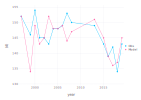

In [30]:
compare(DTS, obs_Naju_CE, :Naju, years_Naju;
    config = config_dts_Naju_CE,
    ylim = (130, 155),
)

In [31]:
rmse_Naju_dts_CE = assess(DTS, obs_Naju_CE, :Naju, years_Naju;
    config = config_dts_Naju_CE,
    metric = :rmse,
)

4.856772106463062 d

#### GDD

In [32]:
configure(:Naju, years_Naju[1])

data,=,258×3 DataFrame…
init,=,"ZonedDateTime(1996, 10, 1, tz""Asia/Seoul"")"
last,=,"ZonedDateTime(1997, 6, 15, tz""Asia/Seoul"")"
step,=,1 d


In [33]:
parameters(GDD)

data,=,nothing
Tb,=,nothing
To,=,nothing
Rg,=,nothing


In [34]:
simulate(GDD;
    config = @config(
        configure(:Naju, years_Naju[1]),
        GDD => (;
            Tb = 4,
            To = 20,
            Rg = 400,
        ),
    ),
    stop = :stop,
)

Row,time,date,T,Tb,To,Rg,y,doy,GDD,cGDD,match,stop
,Quantity…,Date,Quantity…,Quantity…,Quantity…,Quantity…,Int64,Quantity…,Quantity…,Quantity…,Bool,Bool
1,0.0 hr,1996-10-01,17.4 °C,4.0 °C,20.0 °C,400.0 d K,1997,275 d,13.4 K,0.0 d K,false,false
2,24.0 hr,1996-10-02,15.6 °C,4.0 °C,20.0 °C,400.0 d K,1997,276 d,11.6 K,13.4 d K,false,false
3,48.0 hr,1996-10-03,15.6 °C,4.0 °C,20.0 °C,400.0 d K,1997,277 d,11.6 K,25.0 d K,false,false
4,72.0 hr,1996-10-04,15.8 °C,4.0 °C,20.0 °C,400.0 d K,1997,278 d,11.8 K,36.6 d K,false,false
5,96.0 hr,1996-10-05,14.7 °C,4.0 °C,20.0 °C,400.0 d K,1997,279 d,10.7 K,48.4 d K,false,false
6,120.0 hr,1996-10-06,14.7 °C,4.0 °C,20.0 °C,400.0 d K,1997,280 d,10.7 K,59.1 d K,false,false
7,144.0 hr,1996-10-07,12.3 °C,4.0 °C,20.0 °C,400.0 d K,1997,281 d,8.3 K,69.8 d K,false,false
8,168.0 hr,1996-10-08,10.9 °C,4.0 °C,20.0 °C,400.0 d K,1997,282 d,6.9 K,78.1 d K,false,false
9,192.0 hr,1996-10-09,11.0 °C,4.0 °C,20.0 °C,400.0 d K,1997,283 d,7.0 K,85.0 d K,false,false


In [35]:
config_gdd_Naju_CE = calibrate(GDD, obs_Naju_CE;
    configs = configure.(:Naju, years_Naju),
    index   = :year,
    target  = :doy,
    parameters = :GDD => (;
        Tb = (0, 20),
        To = (20, 40),
        Rg = (0, 1000),
    ),
    snap = :stop, 
    stop = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 2533 evals, 2448 steps, improv/step: 0.274 (last = 0.2737), fitness=63.000000000
20.01 secs, 4998 evals, 4913 steps, improv/step: 0.309 (last = 0.3432), fitness=63.000000000

Optimization stopped after 5001 steps and 20.38 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 245.45
Function evals per second = 249.62
Improvements/step = 0.31120
Total function evaluations = 5086


Best candidate found: [7.53486, 29.3888, 549.628]

Fitness: 63.000000000



Tb,=,7.53486 °C
To,=,29.3888 °C
Rg,=,549.628 d K


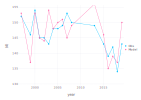

In [36]:
compare(GDD, obs_Naju_CE, :Naju, years_Naju;
    config = config_gdd_Naju_CE,
    ylim = (130, 155),
)

In [37]:
@show typeof(obs_Naju_CE) size(obs_Naju_CE) names(obs_Naju_CE)

# 이상하면 재생성
obs_Naju_CE = select(load_obs(:Naju, :CE), :year, :doy)
met_Naju    = load_met(:Naju)
yrs_weather = unique(year.(met_Naju.date))
obs_Naju_CE = semijoin(obs_Naju_CE, DataFrame(year = yrs_weather), on=:year)

@assert names(obs_Naju_CE) == [:year, :doy] "obs_Naju_CE 컬럼 확인"
@assert nrow(obs_Naju_CE) > 0 "관측×기상 교집합 연도가 없습니다"

years_Naju = collect(obs_Naju_CE.year)

# 이제 OK
compare(GDD, obs_Naju_CE, :Naju, years_Naju; config=config_gdd_Naju_CE, ylim=(130,155))


typeof(obs_Naju_CE) = DataFrame
size(obs_Naju_CE) = (22, 2)
names(obs_Naju_CE) = ["year", "doy"]


LoadError: AssertionError: obs_Naju_CE 컬럼 확인

In [38]:
rmse_Naju_gdd_CE = assess(GDD, obs_Naju_CE, :Naju, years_Naju;
    config = config_gdd_Naju_CE,
    metric = :rmse,
)

4.964580427743055 d

#### Ensemble

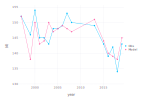

In [39]:
compare2([CF, DTS], obs_Naju_CE, :Naju, years_Naju;
    configs = [config_cf_Naju_CE, config_dts_Naju_CE],
    ylim = (130, 155),
)
     

In [40]:
rmse_Naju_ens_CE = assess2([CF, DTS], obs_Naju_CE, :Naju, years_Naju;
    configs = [config_cf_Naju_CE, config_dts_Naju_CE],
    metric = :rmse,
)

3.4641016151377544 d

### 2.1.2. Naju * K

In [41]:
obs_Naju_K  = load_obs(:Naju, :K)

Row,location,lat,long,alt,year,cultivar,bloom_date,doy
,String7,Missing,Missing,Missing,Int64,String7,Date,Quantity…
1,naju,missing,missing,missing,1999,Kyoho,1999-06-04,155 d
2,naju,missing,missing,missing,2000,Kyoho,2000-06-03,155 d
3,naju,missing,missing,missing,2001,Kyoho,2001-05-28,148 d
4,naju,missing,missing,missing,2002,Kyoho,2002-05-29,149 d
5,naju,missing,missing,missing,2003,Kyoho,2003-05-28,148 d
6,naju,missing,missing,missing,2005,Kyoho,2005-06-02,153 d
7,naju,missing,missing,missing,2006,Kyoho,2006-06-01,152 d
8,naju,missing,missing,missing,2007,Kyoho,2007-06-03,154 d
9,naju,missing,missing,missing,2008,Kyoho,2008-05-30,151 d


In [42]:
years_Naju_K = [1999:2003; 2005:2008; 2015:2019]

14-element Vector{Int64}:
 1999
 2000
 2001
 2002
 2003
 2005
 2006
 2007
 2008
 2015
 2016
 2017
 2018
 2019

In [43]:
# obs_Naju_K.year = Int.(obs_Naju_K.year)
# if !(eltype(obs_Naju_K.doy) <: Unitful.AbstractQuantity)
#     obs_Naju_K.doy .= Int.(obs_Naju_K.doy) .* Unitful.u"d"
# end

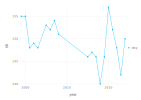

In [44]:
visualize(obs_Naju_K, :year, :doy; kind = :scatterline)

#### CF

In [45]:
config_cf_Naju_K = calibrate(CF, obs_Naju_K;
    configs = configure.(:Naju, years_Naju_K),
    index = :year,
    target = :doy,
    parameters = CF => (;
        Tc = (0, 20),
        Rc = (-1000, 0),
        Rf = (0, 1000),
    ),
    stop = :stop,
    snap = :stop,
    callback
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 2717 evals, 2603 steps, improv/step: 0.256 (last = 0.2562), fitness=23.000000000

Optimization stopped after 5001 steps and 18.53 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 269.86
Function evals per second = 275.95
Improvements/step = 0.22600
Total function evaluations = 5114


Best candidate found: [7.41914, -580.021, 412.038]

Fitness: 23.000000000



Tc,=,7.41914 °C
Rc,=,-580.021 K
Rf,=,412.038 K


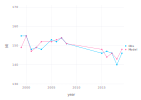

In [46]:
compare(CF, obs_Naju_K, :Naju, years_Naju_K;
    config = config_cf_Naju_K,
    ylim = (130, 170),
)

In [47]:
rmse_Naju_cf_K = assess(CF, obs_Naju_K, :Naju, years_Naju_K;
    config = config_cf_Naju_K,
    metric = :rmse,
)

2.4053511772118195 d

#### DTS

In [48]:
config_dts_Naju_K = calibrate(DTS, obs_Naju_K;
    configs = configure.(:Naju, years_Naju_K),
    index = :year,
    target = :doy,
    parameters = DTS => (;
        Ts = (0, 20),
        Ea = (0, 500),
        Rd = (0, 1000),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 2801 evals, 2692 steps, improv/step: 0.126 (last = 0.1263), fitness=40.000000000

Optimization stopped after 5001 steps and 18.29 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 273.47
Function evals per second = 279.43
Improvements/step = 0.15860
Total function evaluations = 5110


Best candidate found: [12.0553, 302.978, 627.91]

Fitness: 39.000000000



Ts,=,12.0553 °C
Ea,=,302.978 kJ mol^-1
Rd,=,627.91


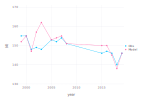

In [49]:
compare(DTS, obs_Naju_K, :Naju, years_Naju_K;
    config = config_dts_Naju_K,
    ylim = (130, 170),
)

In [50]:
rmse_Naju_dts_K = assess(DTS, obs_Naju_K, :Naju, years_Naju_K;
    config = config_dts_Naju_K,
    metric = :rmse,
)

4.6675169293441545 d

#### GDD

In [51]:
config_gdd_Naju_K = calibrate(GDD, obs_Naju_K;
    configs = configure.(:Naju, years_Naju_K),
    index   = :year,
    target  = :doy,
    parameters = GDD => (;
        Tb = (0, 20),
        To = (20, 40),
        Rg = (0, 1000),
    ),
    snap = :stop,
    stop = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 2905 evals, 2811 steps, improv/step: 0.259 (last = 0.2590), fitness=39.000000000

Optimization stopped after 5001 steps and 17.63 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 283.67
Function evals per second = 289.00
Improvements/step = 0.24380
Total function evaluations = 5095


Best candidate found: [17.1668, 23.2256, 32.9804]

Fitness: 37.000000000



Tb,=,17.1668 °C
To,=,23.2256 °C
Rg,=,32.9804 d K


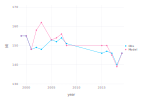

In [52]:
compare(GDD, obs_Naju_K, :Naju, years_Naju_K;
    config = config_gdd_Naju_K,
    ylim = (130, 170),
)

In [53]:
rmse_Naju_gdd_CE = assess(GDD, obs_Naju_K, :Naju, years_Naju;
    config = config_gdd_Naju_K,
    metric = :rmse,
)

4.728334046695819 d

#### Ensemble

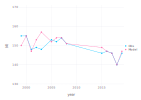

In [54]:
compare2([CF, DTS], obs_Naju_K, :Naju, years_Naju_K;
    configs = [config_cf_Naju_K, config_dts_Naju_K],
    ylim = (130, 170),
)

In [55]:
rmse_Naju_ens_K = assess2([CF, DTS], obs_Naju_K, :Naju, years_Naju_K;
    configs = [config_cf_Naju_K, config_dts_Naju_K],
    metric = :rmse,
)

3.1396087108337016 d

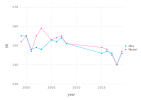

In [56]:
compare2([CF, DTS, GDD], obs_Naju_K, :Naju, years_Naju_K;
    configs = [config_cf_Naju_K, config_dts_Naju_K, config_gdd_Naju_K],
    ylim = (130, 170),
)

In [57]:
assess2([CF, DTS, GDD], obs_Naju_K, :Naju, years_Naju_K;
    configs = [config_cf_Naju_K, config_dts_Naju_K, config_gdd_Naju_K],
    metric = :rmse,
)

3.625307868699863 d

## 2.2. Jinju

In [58]:
met_Jinju = load_met(:Jinju);

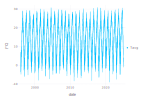

In [59]:
visualize(met_Jinju, :date, :Tavg; kind = :line)

In [60]:
years_Jinju = [1997; 1999:2008; 2013; 2015:2019]

17-element Vector{Int64}:
 1997
 1999
 2000
 2001
 2002
 2003
 2004
 2005
 2006
 2007
 2008
 2013
 2015
 2016
 2017
 2018
 2019

### 2.2.1. Jinju * CE

In [61]:
obs_Jinju_CE = load_obs(:Jinju, :CE)

Row,location,lat,long,alt,year,cultivar,bloom_date,doy
,String7,Missing,Missing,Missing,Int64,String15,Date,Quantity…
1,jinju,missing,missing,missing,1997,Campbell Early,1997-06-01,152 d
2,jinju,missing,missing,missing,1998,Campbell Early,1998-05-18,138 d
3,jinju,missing,missing,missing,1999,Campbell Early,1999-05-26,146 d
4,jinju,missing,missing,missing,2000,Campbell Early,2000-05-28,149 d
5,jinju,missing,missing,missing,2001,Campbell Early,2001-05-22,142 d
6,jinju,missing,missing,missing,2002,Campbell Early,2002-05-13,133 d
7,jinju,missing,missing,missing,2003,Campbell Early,2003-05-26,146 d
8,jinju,missing,missing,missing,2004,Campbell Early,2004-05-20,141 d
9,jinju,missing,missing,missing,2005,Campbell Early,2005-05-16,136 d


In [62]:
# obs_Jinju_CE.year = Int.(obs_Jinju_CE.year)
# if !(eltype(obs_Jinju_CE.doy) <: Unitful.AbstractQuantity)
#     obs_Jinju_CE.doy .= Int.(obs_Jinju_CE.doy) .* Unitful.u"d"
# end

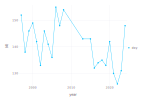

In [63]:
visualize(obs_Jinju_CE, :year, :doy; kind = :scatterline)

#### CF

In [64]:
config_cf_Jinju_CE = calibrate(CF, obs_Jinju_CE;
    configs = configure.(:Jinju, years_Jinju),
    index = :year,
    target = :doy,
    parameters = :CF => (;
        Tc = (0, 20),
        Rc = (-1000, 0),
        Rf = (0, 1000),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 2241 evals, 2181 steps, improv/step: 0.252 (last = 0.2522), fitness=81.000000000
20.00 secs, 4486 evals, 4428 steps, improv/step: 0.208 (last = 0.1647), fitness=76.000000000

Optimization stopped after 5001 steps and 22.71 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 220.25
Function evals per second = 222.80
Improvements/step = 0.20120
Total function evaluations = 5059


Best candidate found: [8.68098, -3.01074, 355.415]

Fitness: 76.000000000



Tc,=,8.68098 °C
Rc,=,-3.01074 K
Rf,=,355.415 K


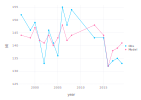

In [65]:
compare(CF, obs_Jinju_CE, :Jinju, years_Jinju;
    config = config_cf_Jinju_CE,
    ylim = (125, 155),
)

In [66]:
rmse_Jinju_cf_CE = assess(CF, obs_Jinju_CE, :Jinju, years_Jinju;
    config = config_cf_Jinju_CE,
    metric = :rmse,
)

5.434097143473411 d

#### DTS

In [67]:
config_dts_Jinju_CE = calibrate(DTS, obs_Jinju_CE;
    configs = configure.(:Jinju, years_Jinju),
    index = :year,
    target = :doy,
    parameters = :DTS => (;
        Ts = (0, 20),
        Ea = (0, 500),
        Rd = (0, 1000),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 2337 evals, 2244 steps, improv/step: 0.144 (last = 0.1439), fitness=105.000000000
20.00 secs, 4598 evals, 4506 steps, improv/step: 0.118 (last = 0.0928), fitness=103.000000000

Optimization stopped after 5001 steps and 22.24 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 224.87
Function evals per second = 229.01
Improvements/step = 0.11760
Total function evaluations = 5093


Best candidate found: [8.29296, 18.1989, 231.716]

Fitness: 102.000000000



Ts,=,8.29296 °C
Ea,=,18.1989 kJ mol^-1
Rd,=,231.716


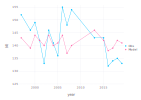

In [68]:
compare(DTS, obs_Jinju_CE, :Jinju, years_Jinju;
    config = config_dts_Jinju_CE,
    ylim = (125, 155),
)

In [69]:
rmse_Jinju_dts_CE = assess(DTS, obs_Jinju_CE, :Jinju, years_Jinju;
    config = config_dts_Jinju_CE,
    metric = :rmse,
)

7.095980635294222 d

#### GDD

In [70]:
config_gdd_Jinju_CE = calibrate(GDD, obs_Jinju_CE;
    configs = configure.(:Jinju, years_Jinju),
    index   = :year,
    target  = :doy,
    parameters = :GDD => (;
        Tb = (0, 20),
        To = (20, 40),
        Rg = (0, 1000),
    ),
    snap = :stop, 
    stop = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 2259 evals, 2182 steps, improv/step: 0.239 (last = 0.2388), fitness=108.000000000
20.00 secs, 4519 evals, 4443 steps, improv/step: 0.245 (last = 0.2503), fitness=107.000000000

Optimization stopped after 5001 steps and 22.41 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 223.20
Function evals per second = 226.59
Improvements/step = 0.25820
Total function evaluations = 5077


Best candidate found: [9.84136, 20.0715, 445.841]

Fitness: 107.000000000



Tb,=,9.84136 °C
To,=,20.0715 °C
Rg,=,445.841 d K


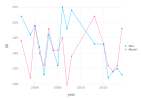

In [71]:
compare(GDD, obs_Jinju_CE, :Jinju, years_Jinju;
    config = config_gdd_Jinju_CE,
    ylim = (130, 155),
)

In [72]:
rmse_Jinju_gdd_CE = assess(GDD, obs_Jinju_CE, :Jinju, years_Jinju;
    config = config_gdd_Jinju_CE,
    metric = :rmse,
)

8.781665392100951 d

#### Ensemble

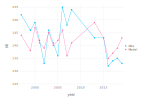

In [73]:
compare2([CF, DTS, GDD], obs_Jinju_CE, :Jinju, years_Jinju;
    configs = [config_cf_Jinju_CE, config_dts_Jinju_CE, config_gdd_Jinju_CE],
    ylim = (125, 155),
)

In [74]:
rmse_Jinju_ens_CE = assess2([CF, DTS, GDD], obs_Jinju_CE, :Jinju, years_Jinju;
    configs = [config_cf_Jinju_CE, config_dts_Jinju_CE, config_gdd_Jinju_CE],
    metric = :rmse,
)

6.734459234153147 d

### 2.2.2. Jinju * K

In [75]:
obs_Jinju_K  = load_obs(:Jinju, :K)

Row,location,lat,long,alt,year,cultivar,bloom_date,doy
,String7,Missing,Missing,Missing,Int64,String7,Date,Quantity…
1,jinju,missing,missing,missing,1998,Kyoho,1998-05-23,143 d
2,jinju,missing,missing,missing,1999,Kyoho,1999-06-04,155 d
3,jinju,missing,missing,missing,2000,Kyoho,2000-06-05,157 d
4,jinju,missing,missing,missing,2001,Kyoho,2001-06-01,152 d
5,jinju,missing,missing,missing,2002,Kyoho,2002-06-04,155 d
6,jinju,missing,missing,missing,2003,Kyoho,2003-06-03,154 d
7,jinju,missing,missing,missing,2004,Kyoho,2004-06-01,153 d
8,jinju,missing,missing,missing,2005,Kyoho,2005-05-27,147 d
9,jinju,missing,missing,missing,2006,Kyoho,2006-06-04,155 d


In [76]:
years_Jinju_K = [1998:2008; 2013; 2015:2019]

17-element Vector{Int64}:
 1998
 1999
 2000
 2001
 2002
 2003
 2004
 2005
 2006
 2007
 2008
 2013
 2015
 2016
 2017
 2018
 2019

In [77]:
# obs_Jinju_K.year = Int.(obs_Jinju_K.year)
# if !(eltype(obs_Jinju_K.doy) <: Unitful.AbstractQuantity)
#     obs_Jinju_K.doy .= Int.(obs_Jinju_K.doy) .* Unitful.u"d"
# end

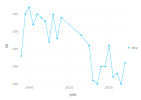

In [78]:
visualize(obs_Jinju_K, :year, :doy; kind = :scatterline)

#### CF

In [79]:
config_cf_Jinju_K = calibrate(CF, obs_Jinju_K;
    configs = configure.(:Jinju, years_Jinju_K),
    index = :year,
    target = :doy,
    parameters = :CF => (;
        Tc = (0, 20),
        Rc = (-1000, 0),
        Rf = (0, 1000),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 2299 evals, 2229 steps, improv/step: 0.248 (last = 0.2476), fitness=85.000000000
20.00 secs, 4598 evals, 4528 steps, improv/step: 0.249 (last = 0.2497), fitness=79.000000000

Optimization stopped after 5001 steps and 22.02 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 227.13
Function evals per second = 230.31
Improvements/step = 0.25760
Total function evaluations = 5071


Best candidate found: [16.3655, -0.903534, 63.946]

Fitness: 79.000000000



Tc,=,16.3655 °C
Rc,=,-0.903534 K
Rf,=,63.946 K


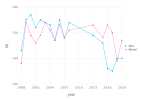

In [80]:
compare(CF, obs_Jinju_K, :Jinju, years_Jinju_K;
    config = config_cf_Jinju_K,
    ylim = (130, 160),
)

In [81]:
rmse_Jinju_cf_K = assess(CF, obs_Jinju_K, :Jinju, years_Jinju_K;
    config = config_cf_Jinju_K,
    metric = :rmse,
)

6.6994292996625076 d

#### DTS

In [82]:
config_dts_Jinju_K = calibrate(DTS, obs_Jinju_K;
    configs = configure.(:Jinju, years_Jinju_K),
    index = :year,
    target = :doy,
    parameters = :DTS => (;
        Ts = (0, 20),
        Ea = (0, 500),
        Rd = (0, 1000),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 2374 evals, 2265 steps, improv/step: 0.125 (last = 0.1245), fitness=98.000000000
20.01 secs, 4712 evals, 4604 steps, improv/step: 0.114 (last = 0.1030), fitness=94.000000000

Optimization stopped after 5001 steps and 21.73 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 230.12
Function evals per second = 235.09
Improvements/step = 0.11240
Total function evaluations = 5109


Best candidate found: [11.6136, 13.1653, 228.042]

Fitness: 94.000000000



Ts,=,11.6136 °C
Ea,=,13.1653 kJ mol^-1
Rd,=,228.042


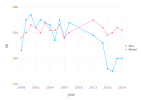

In [83]:
compare(DTS, obs_Jinju_K, :Jinju, years_Jinju_K;
    config = config_dts_Jinju_K,
    ylim = (130, 160),
)

In [84]:
rmse_Jinju_dts_K = assess(DTS, obs_Jinju_K, :Jinju, years_Jinju_K;
    config = config_dts_Jinju_K,
    metric = :rmse,
)

7.120806299355515 d

#### GDD

In [85]:
config_gdd_Jinju_K = calibrate(GDD, obs_Jinju_K;
    configs = configure.(:Jinju, years_Jinju_K),
    index   = :year,
    target  = :doy,
    parameters = :GDD => (;
        Tb = (0, 20),
        To = (20, 40),
        Rg = (0, 1000),
    ),
    snap = :stop, 
    stop = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 2403 evals, 2326 steps, improv/step: 0.240 (last = 0.2403), fitness=102.000000000
20.01 secs, 4780 evals, 4704 steps, improv/step: 0.202 (last = 0.1644), fitness=101.000000000

Optimization stopped after 5001 steps and 21.24 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 235.40
Function evals per second = 238.98
Improvements/step = 0.20600
Total function evaluations = 5077


Best candidate found: [7.06627, 21.4567, 857.65]

Fitness: 101.000000000



Tb,=,7.06627 °C
To,=,21.4567 °C
Rg,=,857.65 d K


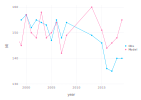

In [86]:
compare(GDD, obs_Jinju_K, :Jinju, years_Jinju;
    config = config_gdd_Jinju_K,
    ylim = (130, 160),
)

In [87]:
rmse_Jinju_gdd_K = assess(GDD, obs_Jinju_K, :Jinju, years_Jinju;
    config = config_gdd_Jinju_K,
    metric = :rmse,
)

7.437237390321759 d

#### Ensemble

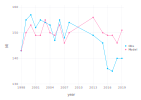

In [88]:
compare2([CF, DTS, GDD], obs_Jinju_K, :Jinju, years_Jinju_K;
    configs = [config_cf_Jinju_K, config_dts_Jinju_K, config_gdd_Jinju_K],
    ylim = (130, 160),
)

In [89]:
rmse_Jinju_ens_K = assess2([CF, DTS, GDD], obs_Jinju_K, :Jinju, years_Jinju;
    configs = [config_cf_Jinju_K, config_dts_Jinju_K, config_gdd_Jinju_K],
    metric = :rmse,
)

6.6661458129866915 d

## 2.3. Okcheon

In [90]:
met_Okcheon = load_met(:Okcheon);

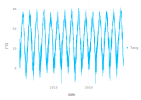

In [91]:
visualize(met_Okcheon, :date, :Tavg; kind = :line)

In [92]:
years_Okcheon = [2013; 2015:2019]

6-element Vector{Int64}:
 2013
 2015
 2016
 2017
 2018
 2019

### 2.3.1. Okcheon * CE

In [93]:
obs_Okcheon_CE = load_obs(:Okcheon, :CE)

Row,location,lat,long,alt,year,cultivar,bloom_date,doy
,String7,Missing,Missing,Missing,Int64,String15,Date,Quantity…
1,okcheon,missing,missing,missing,1997,Campbell Early,1997-06-01,152 d
2,okcheon,missing,missing,missing,1998,Campbell Early,1998-05-25,145 d
3,okcheon,missing,missing,missing,1999,Campbell Early,1999-05-26,146 d
4,okcheon,missing,missing,missing,2000,Campbell Early,2000-05-30,151 d
5,okcheon,missing,missing,missing,2001,Campbell Early,2001-05-20,140 d
6,okcheon,missing,missing,missing,2002,Campbell Early,2002-05-20,140 d
7,okcheon,missing,missing,missing,2003,Campbell Early,2003-05-27,147 d
8,okcheon,missing,missing,missing,2004,Campbell Early,2004-05-25,146 d
9,okcheon,missing,missing,missing,2005,Campbell Early,2005-05-28,148 d


In [94]:
# obs_Okcheon_CE.year = Int.(obs_Okcheon_CE.year)
# if !(eltype(obs_Okcheon_CE.doy) <: Unitful.AbstractQuantity)
#     obs_Okcheon_CE.doy .= Int.(obs_Okcheon_CE.doy) .* Unitful.u"d"
# end

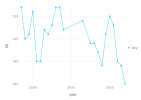

In [95]:
visualize(obs_Okcheon_CE, :year, :doy; kind = :scatterline)

#### CF

In [96]:
config_cf_Okcheon_CE = calibrate(CF, obs_Okcheon_CE;
    configs = configure.(:Okcheon, years_Okcheon),
    index = :year,
    target = :doy,
    parameters = :CF => (;
        Tc = (0, 20),
        Rc = (-1000, 0),
        Rf = (0, 1000),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 5001 steps and 7.96 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 627.91
Function evals per second = 636.70
Improvements/step = 0.26900
Total function evaluations = 5071


Best candidate found: [7.55671, -402.07, 433.488]

Fitness: 4.000000000



Tc,=,7.55671 °C
Rc,=,-402.07 K
Rf,=,433.488 K


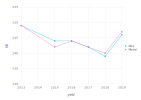

In [97]:
compare(CF, obs_Okcheon_CE, :Okcheon, years_Okcheon;
    config = config_cf_Okcheon_CE,
    ylim = (130, 155),
)

In [98]:
rmse_Okcheon_cf_CE = assess(CF, obs_Okcheon_CE, :Okcheon, years_Okcheon;
    config = config_cf_Okcheon_CE,
    metric = :rmse,
)

1.0 d

#### DTS

In [99]:
config_dts_Okcheon_CE = calibrate(DTS, obs_Okcheon_CE;
    configs = configure.(:Okcheon, years_Okcheon),
    index = :year,
    target = :doy,
    parameters = :DTS => (;
        Ts = (0, 20),
        Ea = (0, 500),
        Rd = (0, 1000),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 5001 steps and 7.76 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 644.15
Function evals per second = 657.80
Improvements/step = 0.12160
Total function evaluations = 5107


Best candidate found: [12.0127, 199.534, 384.313]

Fitness: 14.000000000



Ts,=,12.0127 °C
Ea,=,199.534 kJ mol^-1
Rd,=,384.313


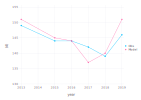

In [100]:
compare(DTS, obs_Okcheon_CE, :Okcheon, years_Okcheon;
    config = config_dts_Okcheon_CE,
    ylim = (130, 155),
)

In [101]:
rmse_Okcheon_dts_CE = assess(DTS, obs_Okcheon_CE, :Okcheon, years_Okcheon;
    config = config_dts_Okcheon_CE,
    metric = :rmse,
)

3.0550504633038935 d

#### GDD

In [102]:
config_gdd_Okcheon_CE = calibrate(GDD, obs_Okcheon_CE;
    configs = configure.(:Okcheon, years_Okcheon),
    index   = :year,
    target  = :doy,
    parameters = :GDD => (;
        Tb = (0, 20),
        To = (20, 40),
        Rg = (0, 1000),
    ),
    snap = :stop, 
    stop = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 5001 steps and 7.48 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 668.29
Function evals per second = 682.45
Improvements/step = 0.24220
Total function evaluations = 5107


Best candidate found: [16.1856, 21.211, 72.1658]

Fitness: 7.000000000



Tb,=,16.1856 °C
To,=,21.211 °C
Rg,=,72.1658 d K


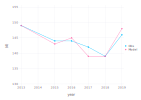

In [103]:
compare(GDD, obs_Okcheon_CE, :Okcheon, years_Okcheon;
    config = config_gdd_Okcheon_CE,
    ylim = (130, 155),
)

In [104]:
rmse_Okcheon_gdd_CE = assess(GDD, obs_Okcheon_CE, :Okcheon, years_Okcheon;
    config = config_gdd_Okcheon_CE,
    metric = :rmse,
)

1.5811388300841898 d

#### Ensemble

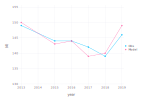

In [105]:
compare2([CF, DTS, GDD], obs_Okcheon_CE, :Okcheon, years_Okcheon;
    configs = [config_cf_Okcheon_CE, config_dts_Okcheon_CE, config_gdd_Okcheon_CE],
    ylim = (130, 155),
)

In [106]:
rmse_Okcheon_ens_CE = assess2([CF, DTS, GDD], obs_Okcheon_CE, :Okcheon, years_Okcheon;
    configs = [config_cf_Okcheon_CE, config_dts_Okcheon_CE, config_gdd_Okcheon_CE],
    metric = :rmse,
)

1.8708286933869707 d

### 2.1.2. Okchoen * K

In [107]:
obs_Okcheon_K  = load_obs(:Okcheon, :K)

Row,location,lat,long,alt,year,cultivar,bloom_date,doy
,String7,Missing,Missing,Missing,Int64,String7,Date,Quantity…
1,okcheon,missing,missing,missing,1999,Kyoho,1999-06-04,155 d
2,okcheon,missing,missing,missing,2002,Kyoho,2002-05-30,150 d
3,okcheon,missing,missing,missing,2003,Kyoho,2003-06-07,158 d
4,okcheon,missing,missing,missing,2004,Kyoho,2004-06-04,156 d
5,okcheon,missing,missing,missing,2005,Kyoho,2005-06-05,156 d
6,okcheon,missing,missing,missing,2006,Kyoho,2006-06-06,157 d
7,okcheon,missing,missing,missing,2007,Kyoho,2007-06-04,155 d
8,okcheon,missing,missing,missing,2008,Kyoho,2008-06-03,155 d
9,okcheon,missing,missing,missing,2013,Kyoho,2013-06-01,152 d


In [108]:
# obs_Okcheon_K.year = Int.(obs_Okcheon_K.year)
# if !(eltype(obs_Okcheon_K.doy) <: Unitful.AbstractQuantity)
#     obs_Okcheon_K.doy .= Int.(obs_Okcheon_K.doy) .* Unitful.u"d"
# end

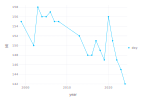

In [109]:
visualize(obs_Okcheon_K, :year, :doy; kind = :scatterline)

#### CF

In [110]:
config_cf_Okcheon_K = calibrate(CF, obs_Okcheon_K;
    configs = configure.(:Okcheon, years_Okcheon),
    index = :year,
    target = :doy,
    parameters = :CF => (;
        Tc = (0, 20),
        Rc = (-1000, 0),
        Rf = (0, 1000),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 5001 steps and 7.86 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 636.50
Function evals per second = 645.40
Improvements/step = 0.25760
Total function evaluations = 5071


Best candidate found: [14.4685, -6.04297, 123.957]

Fitness: 7.000000000



Tc,=,14.4685 °C
Rc,=,-6.04297 K
Rf,=,123.957 K


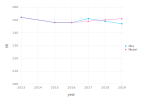

In [111]:
compare(CF, obs_Okcheon_K, :Okcheon, years_Okcheon;
    config = config_cf_Okcheon_K,
    ylim = (100, 160),
)

In [112]:
rmse_Okcheon_cf_K = assess(CF, obs_Okcheon_K, :Okcheon, years_Okcheon;
    config = config_cf_Okcheon_K,
    metric = :rmse,
)

1.8708286933869707 d

#### DTS

In [113]:
config_dts_Okcheon_K = calibrate(DTS, obs_Okcheon_K;
    configs = configure.(:Okcheon, years_Okcheon),
    index = :year,
    target = :doy,
    parameters = :DTS => (;
        Ts = (0, 20),
        Ea = (0, 500),
        Rd = (0, 1000),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 5001 steps and 7.72 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 647.63
Function evals per second = 658.25
Improvements/step = 0.13840
Total function evaluations = 5083


Best candidate found: [9.52873, 9.38715, 238.184]

Fitness: 8.000000000



Ts,=,9.52873 °C
Ea,=,9.38715 kJ mol^-1
Rd,=,238.184


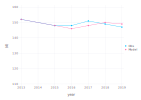

In [114]:
compare(DTS, obs_Okcheon_K, :Okcheon, years_Okcheon;
    config = config_dts_Okcheon_K,
    ylim = (110, 160),
)

In [115]:
rmse_Okcheon_dts_K = assess(DTS, obs_Okcheon_K, :Okcheon, years_Okcheon;
    config = config_dts_Okcheon_K,
    metric = :rmse,
)

1.7320508075688772 d

#### GDD

In [116]:
config_gdd_Okcheon_K = calibrate(GDD, obs_Okcheon_K;
    configs = configure.(:Okcheon, years_Okcheon),
    index   = :year,
    target  = :doy,
    parameters = :GDD => (;
        Tb = (0, 20),
        To = (20, 40),
        Rg = (0, 1000),
    ),
    snap = :stop, 
    stop = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 5001 steps and 7.63 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 655.85
Function evals per second = 667.92
Improvements/step = 0.22960
Total function evaluations = 5093


Best candidate found: [15.7769, 21.427, 113.149]

Fitness: 19.000000000



Tb,=,15.7769 °C
To,=,21.427 °C
Rg,=,113.149 d K


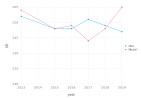

In [117]:
compare(GDD, obs_Okcheon_K, :Okcheon, years_Okcheon;
    config = config_gdd_Okcheon_K,
    ylim = (130, 155),
)

In [118]:
rmse_Okcheon_gdd_K = assess(GDD, obs_Okcheon_K, :Okcheon, years_Okcheon;
    config = config_gdd_Okcheon_K,
    metric = :rmse,
)

4.453463071962462 d

#### Ensemble

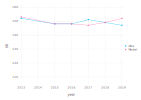

In [119]:
compare2([CF, DTS, GDD], obs_Okcheon_K, :Okcheon, years_Okcheon;
    configs = [config_cf_Okcheon_K, config_dts_Okcheon_K, config_gdd_Okcheon_K],
    ylim = (105, 160),
)

In [120]:
rmse_Okcheon_ens_K = assess2([CF, DTS, GDD], obs_Okcheon_K, :Okcheon, years_Okcheon;
    configs = [config_cf_Okcheon_K, config_dts_Okcheon_K, config_gdd_Okcheon_K],
    metric = :rmse,
)

2.6457513110645907 d

# 3. Predictions

## 3.1. CE

In [121]:
predictions_cf_CE = begin
    S = CF
    years = 2020:2024
    index = :year
    target = :doy
    innerjoin(
        rename!(estimate(S, :Naju,    years; config = config_cf_Naju_CE,    index, target, nounit = true), target => :Naju),
        rename!(estimate(S, :Jinju,   years; config = config_cf_Jinju_CE,   index, target, nounit = true), target => :Jinju),
        rename!(estimate(S, :Okcheon, years; config = config_cf_Okcheon_CE, index, target, nounit = true), target => :Okcheon),
        on = :year
    )
end

Row,year,Naju,Jinju,Okcheon
,Int64,Int64,Int64,Int64
1,2020,365,146,365
2,2021,365,135,365
3,2022,141,139,139
4,2023,138,137,140
5,2024,365,136,365


In [122]:
predictions_dts_CE = begin
    S = DTS
    years = 2020:2024
    index = :year
    target = :doy
    innerjoin(
        rename!(estimate(S, :Naju,    years; config = config_dts_Naju_CE,    index, target, nounit = true), target => :Naju),
        rename!(estimate(S, :Jinju,   years; config = config_dts_Jinju_CE,   index, target, nounit = true), target => :Jinju),
        rename!(estimate(S, :Okcheon, years; config = config_dts_Okcheon_CE, index, target, nounit = true), target => :Okcheon),
        on = :year
    )
end

Row,year,Naju,Jinju,Okcheon
,Int64,Int64,Int64,Int64
1,2020,139,137,147
2,2021,142,138,141
3,2022,133,139,114
4,2023,138,139,142
5,2024,133,136,142


In [123]:
predictions_ensmemble_CE = begin
    Ss = [CF, DTS, GDD]
    years = 2020:2024
    index = :year
    target = :doy
    innerjoin(
        rename!(estimate2(Ss, :Naju,    years; configs = [config_cf_Naju_CE,    config_dts_Naju_CE,    config_gdd_Naju_CE],    index, target, nounit = true), target => :Naju),
        rename!(estimate2(Ss, :Jinju,   years; configs = [config_cf_Jinju_CE,   config_dts_Jinju_CE,   config_gdd_Jinju_CE],   index, target, nounit = true), target => :Jinju),
        rename!(estimate2(Ss, :Okcheon, years; configs = [config_cf_Okcheon_CE, config_dts_Okcheon_CE, config_gdd_Okcheon_CE], index, target, nounit = true), target => :Okcheon),
        on = :year
    )
end

Row,year,Naju,Jinju,Okcheon
,Int64,Quantity…,Quantity…,Quantity…
1,2020,217 d,142 d,219 d
2,2021,218 d,137 d,215 d
3,2022,138 d,138 d,118 d
4,2023,138 d,138 d,143 d
5,2024,209 d,133 d,217 d


In [124]:
CSV.write("grape-predictions_CE.csv", predictions_ensmemble_CE)

"grape-predictions_CE.csv"

## 3.2. K

In [125]:
predictions_cf_K = begin
    S = CF
    years = 2020:2024
    index = :year
    target = :doy
    innerjoin(
        rename!(estimate(S, :Naju,    years; config = config_cf_Naju_K,    index, target, nounit = true), target => :Naju),
        rename!(estimate(S, :Jinju,   years; config = config_cf_Jinju_K,   index, target, nounit = true), target => :Jinju),
        rename!(estimate(S, :Okcheon, years; config = config_cf_Okcheon_K, index, target, nounit = true), target => :Okcheon),
        on = :year
    )
end

Row,year,Naju,Jinju,Okcheon
,Int64,Int64,Int64,Int64
1,2020,154,151,154
2,2021,147,146,146
3,2022,145,146,145
4,2023,143,154,149
5,2024,142,146,148


In [126]:
predictions_dts_K = begin
    S = DTS
    years = 2020:2024
    index = :year
    target = :doy
    innerjoin(
        rename!(estimate(S, :Naju,    years; config = config_dts_Naju_K,    index, target, nounit = true), target => :Naju),
        rename!(estimate(S, :Jinju,   years; config = config_dts_Jinju_K,   index, target, nounit = true), target => :Jinju),
        rename!(estimate(S, :Okcheon, years; config = config_dts_Okcheon_K, index, target, nounit = true), target => :Okcheon),
        on = :year
    )
end

Row,year,Naju,Jinju,Okcheon
,Int64,Int64,Int64,Int64
1,2020,150,148,146
2,2021,154,149,146
3,2022,141,149,147
4,2023,147,149,147
5,2024,151,147,146


In [127]:
predictions_ensmemble_K = begin
    Ss = [CF, DTS, GDD]
    years = 2020:2024
    index = :year
    target = :doy
    innerjoin(
        rename!(estimate2(Ss, :Naju,    years; configs = [config_cf_Naju_K,    config_dts_Naju_K,    config_gdd_Naju_K],    index, target, nounit = true), target => :Naju),
        rename!(estimate2(Ss, :Jinju,   years; configs = [config_cf_Jinju_K,   config_dts_Jinju_K,   config_gdd_Jinju_K],   index, target, nounit = true), target => :Jinju),
        rename!(estimate2(Ss, :Okcheon, years; configs = [config_cf_Okcheon_K, config_dts_Okcheon_K, config_gdd_Okcheon_K], index, target, nounit = true), target => :Okcheon),
        on = :year
    )
end

Row,year,Naju,Jinju,Okcheon
,Int64,Quantity…,Quantity…,Quantity…
1,2020,150 d,149 d,151 d
2,2021,152 d,146 d,147 d
3,2022,140 d,147 d,142 d
4,2023,146 d,149 d,149 d
5,2024,149 d,145 d,147 d


In [128]:
CSV.write("grape-predictions_K.csv", predictions_ensmemble_CE)

"grape-predictions_K.csv"

In [129]:
using DataFrames, CSV

rmse_df = DataFrame(
    Region = ["Naju", "Naju", "Naju",
              "Jinju", "Jinju", "Jinju",
              "Okcheon", "Okcheon", "Okcheon"],
    
    Model = ["CF", "DTS", "Ensemble",
             "CF", "DTS", "Ensemble",
             "CF", "DTS", "Ensemble"],
    
    Code = ["CE", "CE", "CE",
            "CE", "CE", "CE",
            "CE", "CE", "CE"],
    
    RMSE = [rmse_Naju_cf_CE, rmse_Naju_dts_CE, rmse_Naju_ens_CE,
            rmse_Jinju_cf_CE, rmse_Jinju_dts_CE, rmse_Jinju_ens_CE,
            rmse_Okcheon_cf_CE, rmse_Okcheon_dts_CE, rmse_Okcheon_ens_CE]
)


Row,Region,Model,Code,RMSE
,String,String,String,Quantity…
1,Naju,CF,CE,2.14202 d
2,Naju,DTS,CE,4.85677 d
3,Naju,Ensemble,CE,3.4641 d
4,Jinju,CF,CE,5.4341 d
5,Jinju,DTS,CE,7.09598 d
6,Jinju,Ensemble,CE,6.73446 d
7,Okcheon,CF,CE,1.0 d
8,Okcheon,DTS,CE,3.05505 d
9,Okcheon,Ensemble,CE,1.87083 d


In [130]:
append!(rmse_df, DataFrame(
    Region = ["Naju", "Naju", "Naju",
              "Jinju", "Jinju", "Jinju",
              "Okcheon", "Okcheon", "Okcheon"],
    
    Model = ["CF", "DTS", "Ensemble",
             "CF", "DTS", "Ensemble",
             "CF", "DTS", "Ensemble"],
    
    Code = ["K", "K", "K",
            "K", "K", "K",
            "K", "K", "K"],
    
    RMSE = [rmse_Naju_cf_K, rmse_Naju_dts_K, rmse_Naju_ens_K,
            rmse_Jinju_cf_K, rmse_Jinju_dts_K, rmse_Jinju_ens_K,
            rmse_Okcheon_cf_K, rmse_Okcheon_dts_K, rmse_Okcheon_ens_K]
))


Row,Region,Model,Code,RMSE
,String,String,String,Quantity…
1,Naju,CF,CE,2.14202 d
2,Naju,DTS,CE,4.85677 d
3,Naju,Ensemble,CE,3.4641 d
4,Jinju,CF,CE,5.4341 d
5,Jinju,DTS,CE,7.09598 d
6,Jinju,Ensemble,CE,6.73446 d
7,Okcheon,CF,CE,1.0 d
8,Okcheon,DTS,CE,3.05505 d
9,Okcheon,Ensemble,CE,1.87083 d


In [131]:
CSV.write("rmse_summary.csv", rmse_df)


"rmse_summary.csv"

In [132]:
rmse_wide = unstack(rmse_df, [:Region, :Code], :Model, :RMSE)

Row,Region,Code,CF,DTS,Ensemble
,String,String,Quantity…?,Quantity…?,Quantity…?
1,Naju,CE,2.14202 d,4.85677 d,3.4641 d
2,Jinju,CE,5.4341 d,7.09598 d,6.73446 d
3,Okcheon,CE,1.0 d,3.05505 d,1.87083 d
4,Naju,K,2.40535 d,4.66752 d,3.13961 d
5,Jinju,K,6.69943 d,7.12081 d,6.66615 d
6,Okcheon,K,1.87083 d,1.73205 d,2.64575 d


In [133]:
# cols = [:Region, :Code]
# for c in (:CF, :DTS, :Ensemble)
#     if c in names(rmse_wide)
#         push!(cols, c)
#     end
# end
# rmse_wide = rmse_wide[:, cols]

# 2) CSV 저장
CSV.write("rmse_summary_wide.csv", rmse_wide)

"rmse_summary_wide.csv"

In [134]:
CSV.write("rmse_summary_wide.csv", rmse_wide)

"rmse_summary_wide.csv"